# Trees
Archives are stored as trees. A node in the tree may represent 
- a _piece_ (eg an individual bit of the archive subject's correspondence), 
- an _item_ (typical leaf node in the tree, usually a box containing multiple pieces), 
- a _section_, _series_, _subsection_, _subsubseries_, _subsubsubseries_ etc describing the informational hierarchy though which context can be attributed to items and the collection as a whole can be understood, 
- a _collection_, representing the top of the tree and the point at which no context is shared between records of the same rank. 

The CALM data contains many collection level records, some of which are also contextually linked. All of these nodes in the trees are stored as individual rows in the CALM `.json`, and their positions in the hierarchy are described by the `AltRefNo` field. Let's open some up and have a look at their structure.

In [ ]:
from IPython.core.display import display, HTML

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
plt.rcParams['figure.figsize'] = (30, 30)

import pandas as pd
import numpy as np
import networkx as nx

import re

from umap import UMAP
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from tqdm import tqdm_notebook as tqdm

In [ ]:
df = pd.read_json('data/calm_records.json')

In [ ]:
df['AltRefNo']

The `Level` field tells us whether the record is an item, a series, a subsubsection etc. However, I'm going to ignore this as the choice of when to use these hierarchy descriptors is somewhat arbitrary, chosen by the archivist in question to best fit the archive. I'm told that what _really_ matters is the _structure_ of the archive, which is all contained in the `AltRefNo`s.  
We can obtain a little extra useful context from some of these records. The _arrangement_ of each collection is described in the `Arrangement` field of a collection-level record. However, these are inconsistently written and are unlikely to be machine-interpretable any time soon. Still, good to know that they're there

In [ ]:
display(HTML(df['Arrangement'][269057][0]))

The `.json` format adds some noise to data when read into pandas. Let's quickly clean up some of the more useful fields. 

In [ ]:
df['AltRefNo'] = df['AltRefNo'].dropna().apply(lambda x: x[0])
df['Level'] = df['Level'].dropna().apply(lambda x: x[0])

### building a tree
Let's take a look at some of the collection-level records' `AltRefNo`s and use one of them as a starting point for our tree building

In [ ]:
for collection_id in sorted(df['AltRefNo'][df['Level'] == 'Collection'].values):
    print(collection_id)

In [ ]:
alt_ref_no = 'GC/2'

We want to find every record in the DataFrame whose `AltRefNo`s start with the chosen string above:

In [ ]:
codes_as_str = sorted(df['AltRefNo'][df['AltRefNo']
                                     .str.startswith(alt_ref_no)
                                     .fillna(False)]
                      .tolist())
codes_as_str

We'll now clean up the split those codes into lists of parts, using each `/` or `.` as delimiters. We'll then stick these strings and lists into a dictionary together - this is going to be useful in a minute...

In [ ]:
codes = {code: re.split('/|\.', code.strip()) 
         for code in codes_as_str}

len(codes)

### Graph theory and NetworkX
Seeing these lists in sorted order and thinking of them as implicit descriptions of a POSIX-style directory/folder structure, it's easy to see how the archive is divided into a hierarchy. All we need to do now is re-encode that hierarchy explicitly. To do that, we'll use a python package called NetworkX, which allows us to do a lot of basic graph theory (and some complex stuff too).  
As we learned in the last notebook, almost all of graph theory is based on something called an _adjacency matrix_, which describes the links between each node in the network. Each column/row represents a single node, and their intersection represents the strength of the interaction between them. Let's construct an empty matrix which we'll then populate based on the `AltRefNo` information.

In [ ]:
adjacency = pd.DataFrame(data=0, 
                         index=codes_as_str, 
                         columns=codes_as_str)

We'll now iterate through all of the possible `AltRefNo` string/list pairs. If the pair look like they have a parent/child relationship (the child's `AltRefNo` list is one element longer than the parent's and contains the full parent `AltRefNo`), then we change the element from a `0` to a `1`, drawing a connection between them.

In [ ]:
for parent_str, parent_list in tqdm(codes.items()):
    for child_str, child_list in codes.items():
        if child_list == parent_list + [child_list[-1]]:
            adjacency[parent_str][child_str] = 1

We can look at the number of connections drawn out of the $n^{2}$ potential connections.

In [ ]:
pd.Series(np.hstack(adjacency.values)).value_counts()

Recent versions of NetworkX can build a graph from the raw adjacency matrix in pandas DataFrame format, inferring all node names etc.

In [ ]:
G = nx.from_pandas_adjacency(adjacency)

we can now draw our network!

In [ ]:
nx.draw_spring(G, node_size=60)

As shown in the last notebook, we don't have to see adjacency matrices as graphs - they can also be seen as $n$ dimensional spaces, where each $n$D vector describes a position in that space. We can reduce the dimensionality of each vector while preserving as many of the distances between points as possible. UMAP provides a great way of doing this, but other techniques such as PCA and t-SNE also exist. We'll now squish our $n$D vector space down onto a 2D plane using UMAP. Here's what our graph looks like in that free-form 2D space.

In [ ]:
embedding_2d = pd.DataFrame(UMAP(n_components=2)
                            .fit_transform(adjacency))

embedding_2d.plot.scatter(x=0, y=1);

We can use all sorts of techniques to group these points into distinct clusters. Here we'll use agglomerative clustering again

In [ ]:
from sklearn.cluster import AgglomerativeClustering

n_clusters = 15
embedding_2d['labels'] = AgglomerativeClustering(n_clusters).fit_predict(embedding_2d.values)
embedding_2d.plot.scatter(x=0, y=1, c='labels', cmap='Paired');

now we can map those cluster labels back onto our graph nodes, colouring them according to the points with which they share a common feature space.

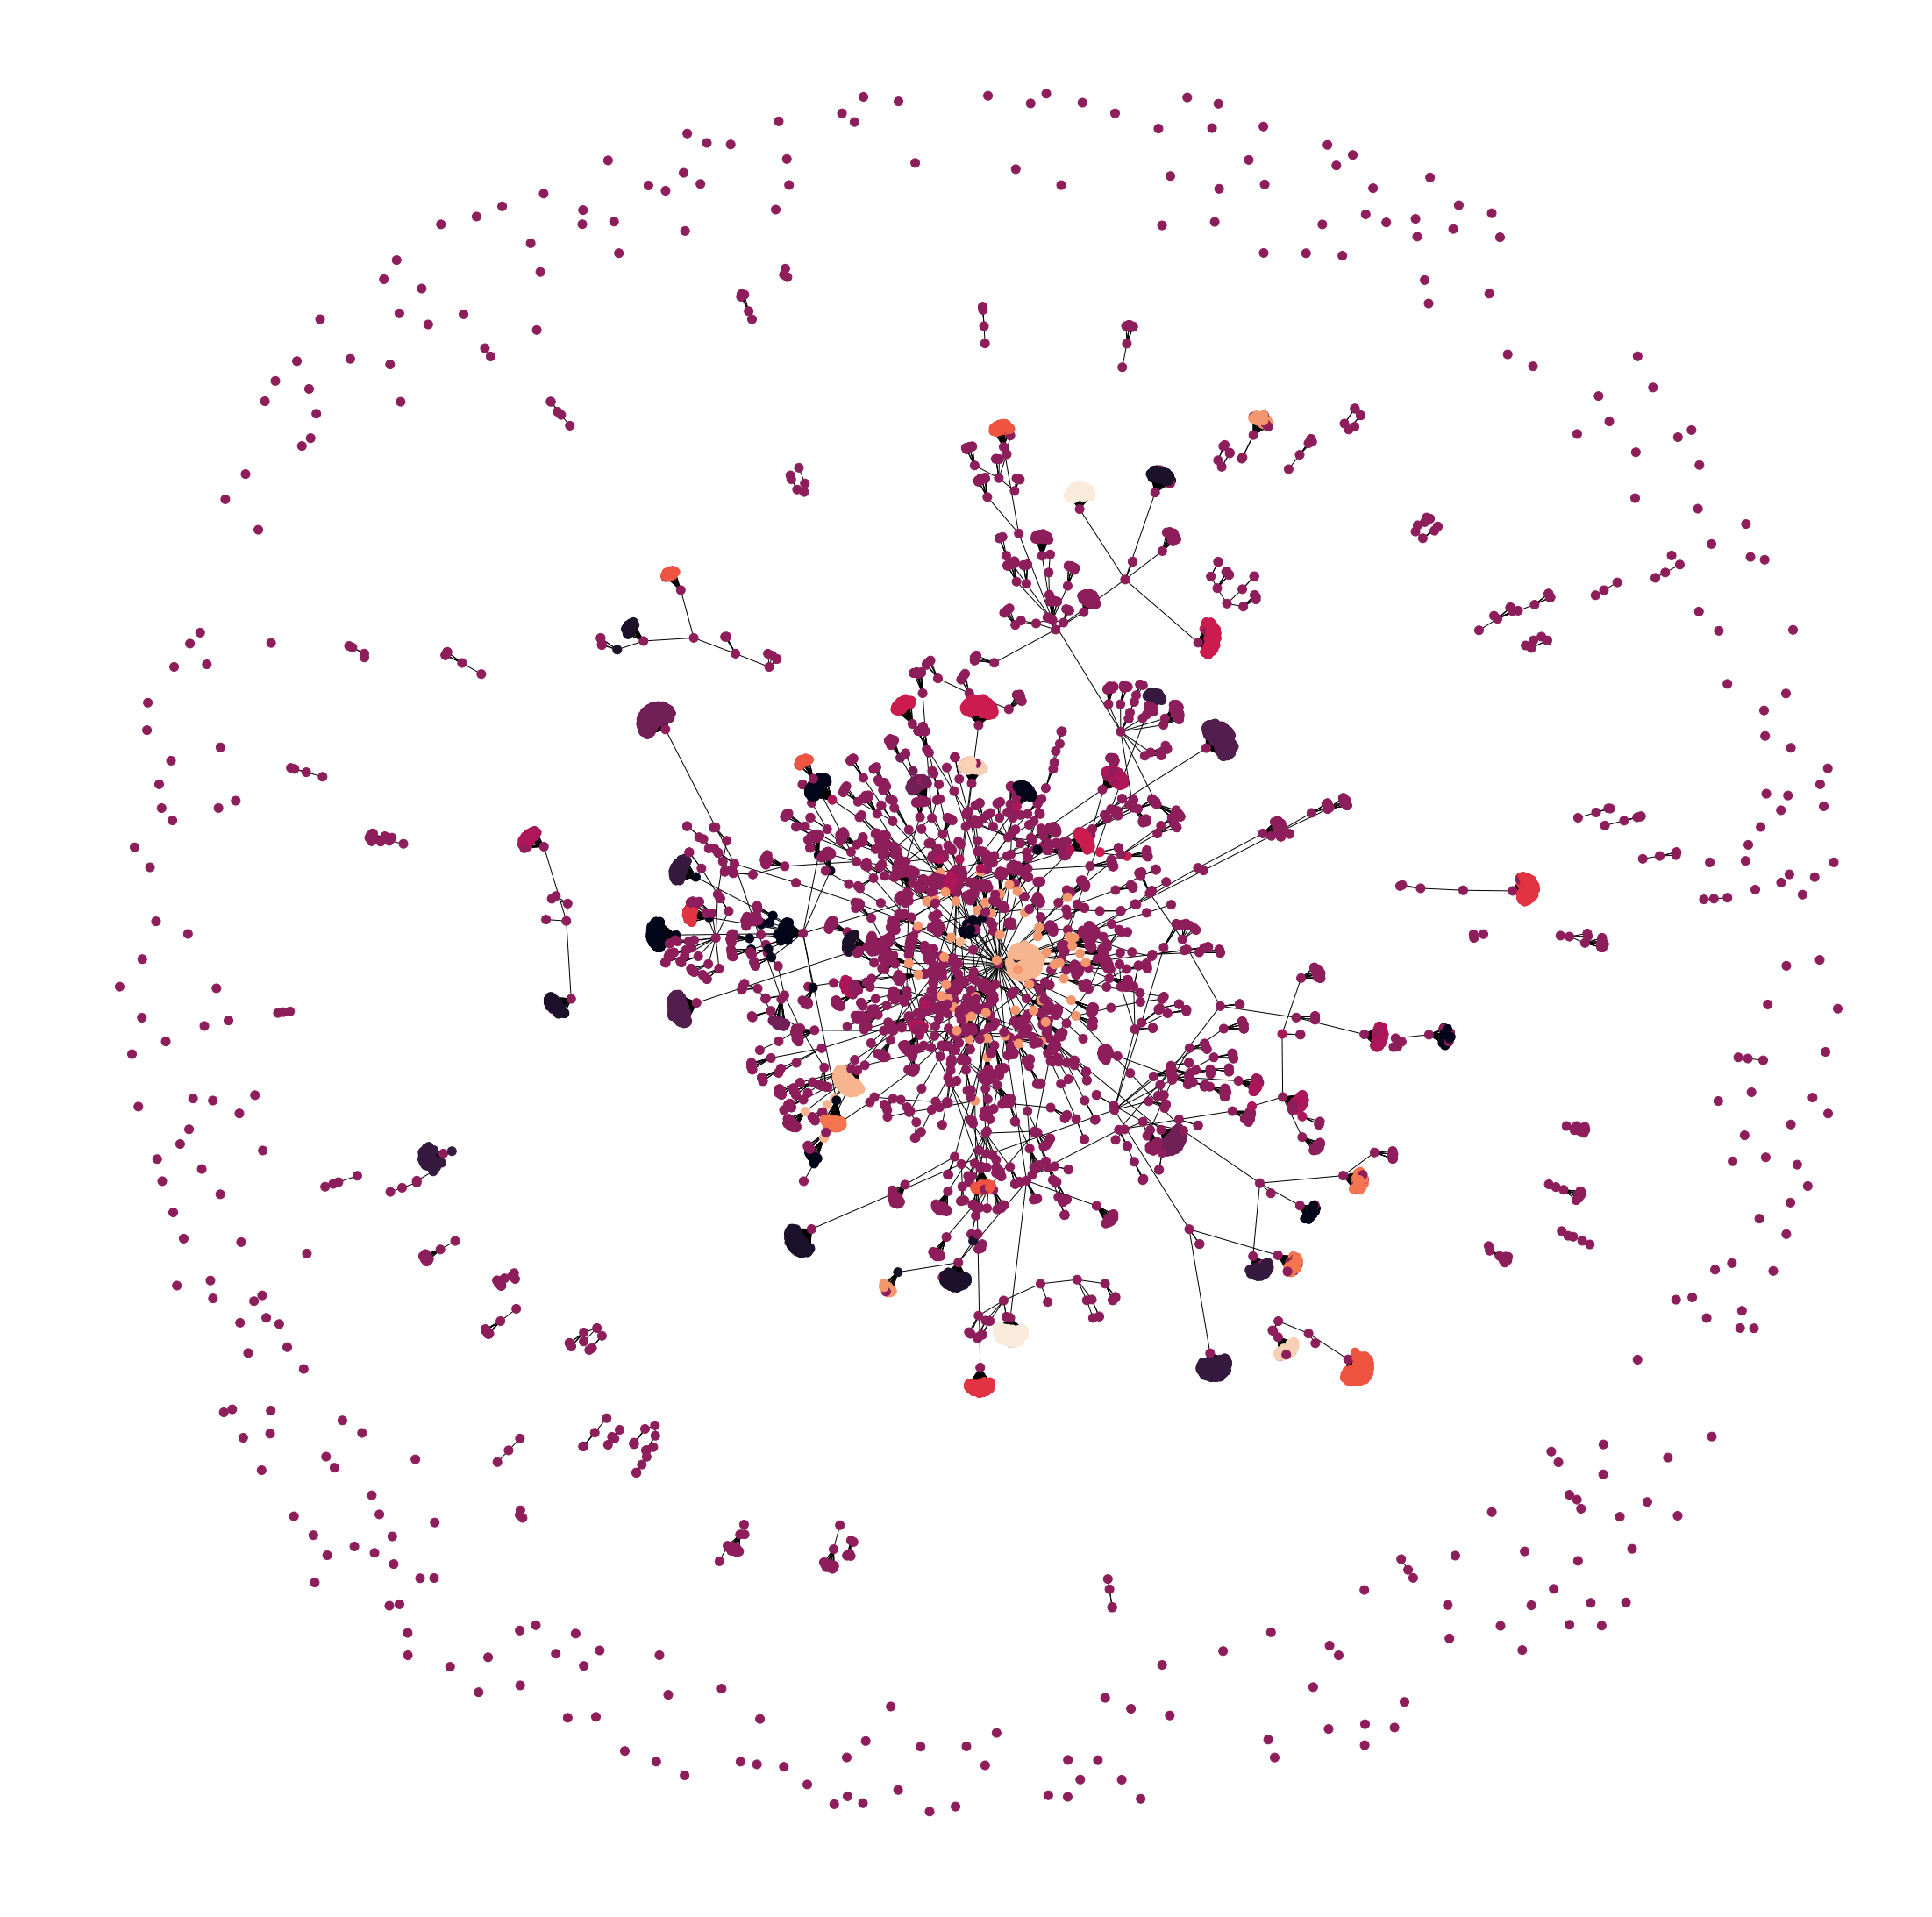

In [88]:
nx.draw_spring(G, node_size=100, 
               node_color=embedding_2d['labels'])

beautiful!

### coping with unusual parents
On closer inspection, some of our leaf nodes seem to not be leaf nodes after all!  
Despite appearing at the same depth as item level records in the series of `/`s, section-level records like `GC/280/28-45` conceptually link many leaf nodes between `GC/280/28` and `GC/280/45`, with its notes and descriptions written in general terms. The fact that they act as parents to the nodes between those `i-j` limits needs to be built in to our view of the trees.

In [ ]:
section_level_codes = adjacency[adjacency.index.str.contains('-')].index.values
section_level_codes

In [ ]:
relevant_prefixes = list(map(lambda x: '/'.join(x.split('/')[:-1]) + '/', 
                             section_level_codes))

all_relevant_codes = [code for code in adjacency.index.values 
                      if any([code.startswith(prefix) for prefix in relevant_prefixes])
                      and '-' not in code ]
all_relevant_codes

In [ ]:
str_to_int = lambda x: int(re.sub('[^0-9]', '', x))

In [ ]:
def find_children(parent_code, all_codes):
    '''
    
    '''

In [ ]:
for code_1 in section_level_codes:
    prefix_1 = '/'.join(code_1.split('/')[:-1]) + '/'
    suffix_1 = code_1.split('/')[-1]
    
    i, j = suffix_1.split('-')
    i, j = str_to_int(i), str_to_int(j)
    
    print(code_1, '     \t', i, '\t', j)
    print('-----------------------------------')
    
    children = []
    print()
    for code in all_relevant_codes:
        prefix_2 = '/'.join(code.split('/')[:len(prefix) - 1]) + '/'
        suffix_2 = str_to_int(code.split('/')[len(prefix)])

        if prefix_1 == prefix_2 and i <= suffix_2 <= j:
            children.append(code)
    print(children, '\n')

In [ ]:
for code in all_relevant_codes: 
    if code.startswith('GC/201/A/1/3'):
        print(code)

In [ ]:
int(re.sub('[^0-9]', '', '26a'))

In [ ]:
print(code_1, '     \t', i, '\t', j, '\n')
code_length = len(code.split('/'))
prefix_1 = '/'.join(code_1.split('/')[:-1]) + '/'
suffix_1 = code_1.split('/')[-1]

i, j = suffix_1.split('-')
i, j = str_to_int(i), str_to_int(j)
    
for code_2 in all_relevant_codes:
    prefix_2 = '/'.join(code_2.split('/')[:code_length - 1]) + '/'
   
    if prefix_1 == prefix_2:
        suffix_2 = str_to_int(code_2.split('/')[code_length - 2])
        if i <= suffix_2 <= j:
            children.append(code)

In [ ]:
code_2.split('/')[4]